## Testing Timer

First version of this document:
- adding in per WFS parallel code. 
- timing that

Second version of this document:
- implementing COrrClock class for inherent timing

In [43]:
import sys
sys.path.append("../")

In [44]:
# imports
import numpy as np
import pandas as pd
import numpy.ma as ma
import importlib
import matplotlib
from astropy.stats import sigma_clipped_stats
from importlib import reload
import time
from astropy.io import fits
import re

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#personal
from pipeline.est_pipeline import *
from pipeline.code.file_reader import *
from pipeline.code.corr_plots import *
from pipeline.code.cluster import *

import pipeline.code.Estimator as es
import pipeline.code.Estimator_R as er
import pipeline.code.data_table as d_t
import pipeline.code.graph_code as gc

import pipeline.code.Correlator as Cor
from importlib import reload

In [45]:
home_dir = "/home/emcewen/"
out_dir = home_dir + "test_lengths/"
data_path = "/home/imaka/data/"

# aocb file:
date = '20210502'
aocb = 'aocb0012o'

# file things
name = f'{date}_{aocb}'
file_path = f'{data_path}{date}/ao/{aocb}.fits'

## Simple timer test

In [105]:
hdu_list = fits.open(file_path)
hdu_list[0].header["NAXIS2"]

6000

In [4]:
# Quick simulation run
#reload(Cor)
# init object
tmax = 50
curr_data = Cor.Correlator(name, file_path, out_dir, tmax=tmax, s_sub=True, tt_sub=True)

# set the range
#curr_data.set_trange([0, 100])
#check that the slopes are the right length:
x_slopes = curr_data.x_slopes
curr_data.x_slopes.shape

(5, 6000, 8, 8)

In [5]:
## A Real correlation 
#run correlations, save, etc

t0 = time.time()
print("Starting ACor")
curr_data.acor_gen()
t1 = time.time()
print("... Finished in ", str(t1-t0))

curr_data.ccor = False
print("Starting XCor")
curr_data.ccor_gen()
t2 = time.time()
print("... Finished in ", str(t2-t1))

print("Writing Fits File")
curr_data.fits_write()
t3 = time.time()
print("... Finished in ", str(t3-t2))

Starting ACor
... Finished in  18.31304931640625
Starting XCor
... Finished in  59.743571281433105
Writing Fits File
... Finished in  0.05988335609436035


In [6]:
## checking clock variables
curr_data.get_clock_time()

(18.312651872634888, 59.742729902267456)

In [8]:
## a parallel correlation
# restarting
curr_data = Cor.Correlator(name, file_path, out_dir, tmax=tmax, s_sub=True, tt_sub=True)

t0 = time.time()
print("Starting parallel ACor")
curr_data.acor_gen_par()
t1 = time.time()
print("... Finished in ", str(t1-t0))

print("Starting parallel XCor")
curr_data.ccor_gen_par()
t2 = time.time()
print("... Finished in ", str(t2-t1))

print("Writing Fits File")
curr_data.fits_write()
t3 = time.time()
print("... Finished in ", str(t3-t2))

Starting parallel ACor
... Finished in  5.269869565963745
Starting XCor
... Finished in  16.206350564956665
Writing Fits File
... Finished in  0.051407575607299805


In [9]:
## checking clock variables
curr_data.get_clock_time()

(5.268973350524902, 16.20549726486206)

In [10]:
curr_data.fits_file

'/home/emcewen/test_lengths/fits/20210502_aocb0012o_tmax50_tts.fits'

In [11]:
## Testing the pull from a fits file

pull_data = Cor.Correlator("", "", "", f_file=curr_data.fits_file)
pull_data.get_clock_time()

(16.20549726486206, 16.20549726486206)

## Test AOCB length params


running: `python3 test_timer.py 20210502`

In [30]:
file = home_dir+"out/20210502/fits/20210502_aocb0008o_tmax200_stt.fits"
cor_ex = Cor.Correlator("", "", "", f_file=file)

In [34]:
cor_ex.x_slopes.shape

(5, 6000, 8, 8)

In [14]:
## Test AOCB length params
# want to check time on all files in this directory

## TODO: your own directory
dir_timer = home_dir + "test_timer/test1/trange/fits/"

files = os.listdir(dir_timer)
tm_data =  [dir_timer + fn for fn in files]

In [29]:
# for file in this directory, add trange and tmax

df_times = pd.DataFrame(columns = ['name','tmax','range', 'time0', 'time1'])

for c_f in tm_data:
    pull_data = Cor.Correlator("", "", "", f_file=c_f)
    df_times=df_times.append({'name': pull_data.name,
                              'tmax': pull_data.tmax,
                              'range': re.search('f0_(.*).fits', c_f).group(1),
                              'time0': pull_data.get_clock_time()[0],
                              'time1': pull_data.get_clock_time()[1]},ignore_index=True)


In [88]:
df_times['range'] = df_times['range'].astype(int)
df_times['time1'] = df_times['time1'].astype(int)

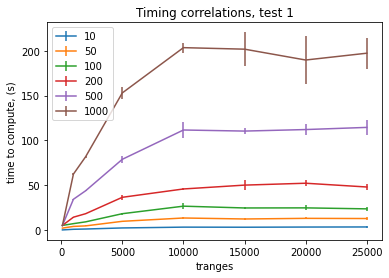

In [112]:
# plotting
ranges = df_times['range'].unique()
tmaxes = df_times['tmax'].unique()
tmaxes.sort()
ranges.sort()

for tmax in tmaxes:
    df_tmp = df_times[df_times['tmax'] == tmax]
    means_tmp = []
    std_tmp = []
    for r in ranges:
        means_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].mean())
        std_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].std())
    plt.errorbar(ranges, means_tmp, yerr=std_tmp, label = tmax)

plt.title("Timing correlations, test 1")
plt.xlabel("tranges")
plt.ylabel("time to compute, (s)")
plt.legend()
#plt.yscale('log')
#plt.xscale('log')
plt.show()

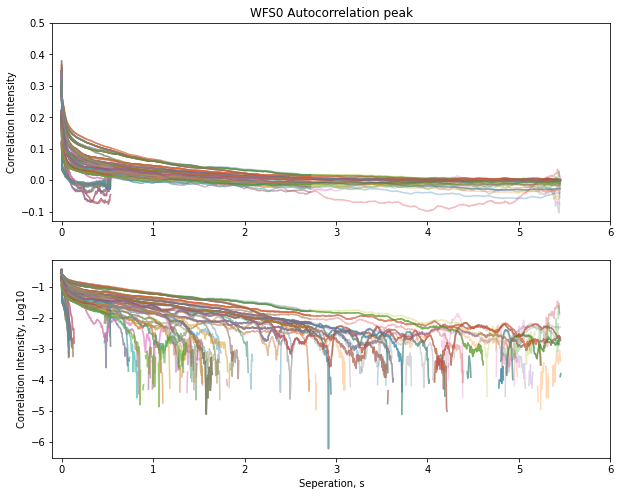

In [116]:
# what do central peaks look like?

fig, ax =  plt.subplots(2,1,figsize=(10,8))
ax[0].set_ylabel('Correlation Intensity')
ax[1].set_ylabel('Correlation Intensity, Log10')
ax[1].set_xlabel('Seperation, s')
ax[0].set_title(f'WFS0 Autocorrelation peak')

# fiding files for this date:
#files_tmp = df_merge[df_merge["DATETIME_tmp"] == d]["outfits_x"]
#f_list = files_tmp.shape[0]

# for each file, pull one wfs, plot on 
#for c, f in enumerate(files_tmp):
for f in tm_data:
    pull_data = Cor.Correlator("", "", "", f_file = f)
    avg_acor = (pull_data.acor_x + pull_data.acor_y)/2
    center_peak_0 = avg_acor[0, :, 7, 7] # takes just WFS 0 peak
    t_coords = np.arange(center_peak_0.shape[0]) # this is the time in frames
    t_coords = t_coords / pull_data.hz_pull()

    ax[0].plot(t_coords, center_peak_0, alpha=0.3)
    # , c=cmap(re.search('f0_(.*).fits', f).group(1)/2500)
    ax[1].plot(t_coords, np.log10(center_peak_0), alpha=0.3)

ax[0].set_ylim(top=0.5)
ax[0].set_xlim(left=-0.1, right=6)
ax[1].set_xlim(left=-0.1, right=6)
plt.show()

In [41]:
df_times2

,name,tmax,range,time0,time1
0,20210502_aocb0011o,10,15000,1.269557,3
1,20210502_aocb0009o,1000,20000,80.188993,218
2,20210502_aocb0010o,500,10000,39.578905,109
3,20210502_aocb0010o,500,1000,17.195645,34
4,20210502_aocb0009o,100,100,2.762368,5
...,...,...,...,...,...
475,20210502_aocb0021o,10,10000,1.261397,3
476,20210502_aocb0019o,100,2000,4.874764,9
477,20210502_aocb0010o,200,2000,9.488792,18
478,20210502_aocb0011o,200,1000,7.177795,14


### Timing, test 2, switched order

In [13]:
## Test AOCB length params
# want to check time on all files in this directory
dir_timer = "/home/emcewen/test_timer/test2/trange/fits/"

files = os.listdir(dir_timer)
tm_data2 =  [dir_timer + fn for fn in files]

In [14]:
# for file in this directory, add trange and tmax

df_times2 = pd.DataFrame(columns = ['name','tmax','range', 'time0', 'time1'])

for c_f in tm_data2:
    pull_data = Cor.Correlator("", "", "", f_file=c_f)
    df_times2=df_times2.append({'name': pull_data.name,
                              'tmax': pull_data.tmax,
                              'range': re.search('f0_(.*).fits', c_f).group(1),
                              'time0': pull_data.get_clock_time()[0],
                              'time1': pull_data.get_clock_time()[1]},ignore_index=True)


In [15]:
df_times2["range"] = df_times2['range'].astype(int)
df_times2['time1'] = df_times2['time1'].astype(int)
df_times2['tmax'] = df_times2['tmax'].astype(int)

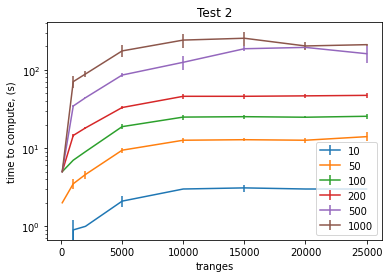

In [11]:
# plotting
ranges = df_times2['range'].unique()
tmaxes = df_times2['tmax'].unique()
tmaxes.sort()
ranges.sort()

for tmax in tmaxes:
    df_tmp = df_times2[df_times2['tmax'] == tmax]
    means_tmp = []
    std_tmp = []
    for r in ranges:
        means_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].mean())
        std_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].std())
    plt.errorbar(ranges, means_tmp, yerr=std_tmp, label = tmax)

plt.title("Test 2")
plt.xlabel("tranges")
plt.ylabel("time to compute, (s)")
plt.legend()
plt.yscale('log')

plt.show()

### Test 3, no parallel

In [7]:
## Test AOCB length params
# want to check time on all files in this directory
dir_timer = "/home/emcewen/test_timer/test3/trange/fits/"

files = os.listdir(dir_timer)
tm_data3 =  [dir_timer + fn for fn in files]

In [8]:
# for file in this directory, add trange and tmax

df_times3 = pd.DataFrame(columns = ['name','tmax','range', 'time0', 'time1'])

for c_f in tm_data3:
    pull_data = Cor.Correlator("", "", "", f_file=c_f)
    df_times3 = df_times3.append({'name': pull_data.name,
                              'tmax': pull_data.tmax,
                              'range': re.search('f0_(.*).fits', c_f).group(1),
                              'time0': pull_data.get_clock_time()[0],
                              'time1': pull_data.get_clock_time()[1]},ignore_index=True)


In [9]:
df_times3["range"] = df_times3['range'].astype(int)
df_times3['time1'] = df_times3['time1'].astype(int)
df_times3['tmax'] = df_times3['tmax'].astype(int)

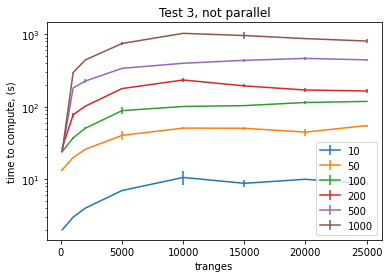

In [10]:
# plotting
ranges = df_times3['range'].unique()
tmaxes = df_times3['tmax'].unique()
tmaxes.sort()
ranges.sort()

for tmax in tmaxes:
    df_tmp = df_times3[df_times3['tmax'] == tmax]
    means_tmp = []
    std_tmp = []
    for r in ranges:
        means_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].mean())
        std_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].std())
    plt.errorbar(ranges, means_tmp, yerr=std_tmp, label = tmax)

plt.title("Test 3, not parallel")
plt.xlabel("tranges")
plt.ylabel("time to compute, (s)")
plt.legend()
plt.yscale('log')

plt.show()

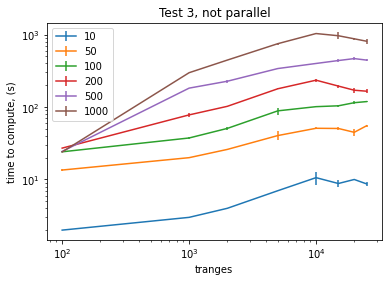

In [11]:
# plotting
ranges = df_times3['range'].unique()
tmaxes = df_times3['tmax'].unique()
tmaxes.sort()
ranges.sort()

for tmax in tmaxes:
    df_tmp = df_times3[df_times3['tmax'] == tmax]
    means_tmp = []
    std_tmp = []
    for r in ranges:
        means_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].mean())
        std_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].std())
    plt.errorbar(ranges, means_tmp, yerr=std_tmp, label = tmax)

plt.title("Test 3, not parallel")
plt.xlabel("tranges")
plt.ylabel("time to compute, (s)")
plt.legend()
plt.yscale('log')
plt.xscale('log')

plt.show()

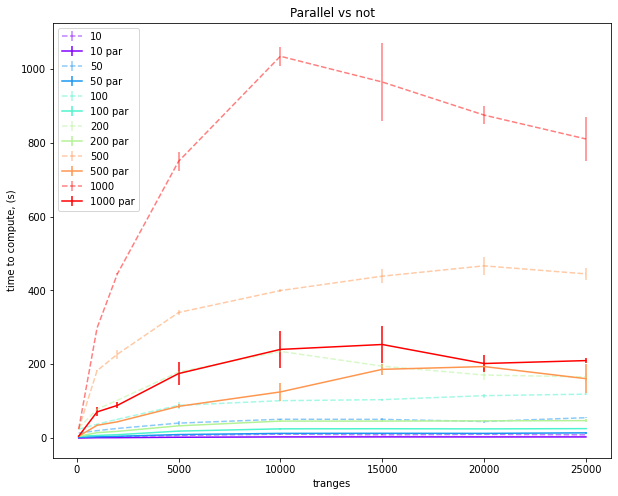

In [86]:
## compare
plt.figure(figsize=(10,8))
# plotting
ranges = df_times3['range'].unique()
tmaxes = df_times3['tmax'].unique()
tmaxes.sort()
ranges.sort()

colors = plt.cm.rainbow(np.linspace(0, 1, tmaxes.shape[0]))


for i, tmax in enumerate(tmaxes):
    df_tmp = df_times3[df_times3['tmax'] == tmax]
    means_tmp = []
    std_tmp = []
    for r in ranges:
        means_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].mean())
        std_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].std())
    
    df_tmp2 = df_times2[df_times2['tmax'] == tmax]
    means_tmp2 = []
    std_tmp2 = []
    for r in ranges:
        means_tmp2.append(df_tmp2[df_tmp2['range'] == r]['time1'].mean())
        std_tmp2.append(df_tmp2[df_tmp2['range'] == r]['time1'].std())
    
    plt.errorbar(ranges, means_tmp, yerr=std_tmp, color=colors[i],   fmt='--', alpha=0.5, label = tmax)
    plt.errorbar(ranges, means_tmp2, yerr=std_tmp2, color=colors[i], label = str(tmax) + " par")

plt.title("Parallel vs not")
plt.xlabel("tranges")
plt.ylabel("time to compute, (s)")
plt.legend()
#plt.yscale('log')

plt.show()

### Test 4: long aocb

In [46]:
## Test AOCB length params
# want to check time on all files in this directory
dir_timer = "/home/emcewen/test_timer/test4/20210502/fits/"

files = os.listdir(dir_timer)
tm_data4 = [dir_timer + fn for fn in files]

In [47]:
# for file in this directory, add trange and tmax

df_times4 = pd.DataFrame(columns = ['name','tmax','range', 'time0', 'time1'])

for c_f in tm_data4:
    pull_data = Cor.Correlator("", "", "", f_file=c_f)
    df_times4 = df_times4.append({'name': pull_data.name,
                              'tmax': pull_data.tmax,
                              'range': re.search('f0_(.*).fits', c_f).group(1),
                              'time0': pull_data.get_clock_time()[0],
                              'time1': pull_data.get_clock_time()[1]},ignore_index=True)
#df_times4["range"] = df_times4['range'].astype(int)
#df_times4['time1'] = df_times4['time1'].astype(int)
#df_times4['tmax'] = df_times4['tmax'].astype(int)
    

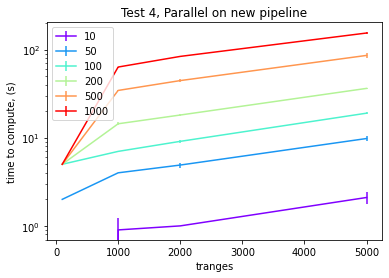

In [63]:
df_plot = df_times4

# plotting
ranges = df_plot['range'].unique()
tmaxes = df_plot['tmax'].unique()
tmaxes.sort()
ranges.sort()

colors = plt.cm.rainbow(np.linspace(0, 1, tmaxes.shape[0]))

for i, tmax in enumerate(tmaxes):
    df_tmp = df_plot[df_plot['tmax'] == tmax]
    means_tmp = []
    std_tmp = []
    for r in ranges:
        means_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].mean())
        std_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].std())
    plt.errorbar(ranges, means_tmp, yerr=std_tmp, color=colors[i], label = tmax)

plt.title("Test 4, Parallel on new pipeline")
plt.xlabel("tranges")
plt.ylabel("time to compute, (s)")
plt.legend()
plt.yscale('log')

plt.show()

### Test 4.1: With longer file

In [67]:
## Test AOCB length params
# want to check time on all files in this directory
dir_timer = "/home/emcewen/test_timer/test4/20210827/fits/"

files = os.listdir(dir_timer)
tm_data41 = [dir_timer + fn for fn in files]

In [68]:
# for file in this directory, add trange and tmax

df_times41 = pd.DataFrame(columns = ['name','tmax','range', 'time0', 'time1'])

for c_f in tm_data41:
    pull_data = Cor.Correlator("", "", "", f_file=c_f)
    df_times41 = df_times41.append({'name': pull_data.name,
                              'tmax': pull_data.tmax,
                              'range': re.search('f0_(.*).fits', c_f).group(1),
                              'time0': pull_data.get_clock_time()[0],
                              'time1': pull_data.get_clock_time()[1]},ignore_index=True)

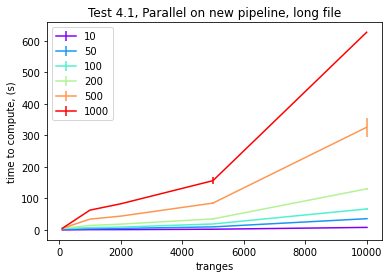

In [69]:
df_plot = df_times41
df_plot["range"] = df_plot['range'].astype(int)
df_plot['time1'] = df_plot['time1'].astype(int)
df_plot['tmax'] = df_plot['tmax'].astype(int)

# plotting
ranges = df_plot['range'].unique()
tmaxes = df_plot['tmax'].unique()
tmaxes.sort()
ranges.sort()

for i, tmax in enumerate(tmaxes):
    df_tmp = df_plot[df_plot['tmax'] == tmax]
    means_tmp = []
    std_tmp = []
    for r in ranges:
        means_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].mean())
        std_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].std())
    plt.errorbar(ranges, means_tmp, yerr=std_tmp, color=colors[i], label = tmax)

plt.title("Test 4.1, Parallel on new pipeline, long file")
plt.xlabel("tranges")
plt.ylabel("time to compute, (s)")
plt.legend()
#plt.yscale('log')

plt.show()

## test 5: parallel files

In [88]:
## Test AOCB length params
# want to check time on all files in this directory
dir_timer = "/home/emcewen/test_timer/test5/20210827/fits/"

files = os.listdir(dir_timer)
tm_data5 = [dir_timer + fn for fn in files]

In [89]:
# for file in this directory, add trange and tmax

df_times5 = pd.DataFrame(columns = ['name','tmax','range', 'time0', 'time1'])

for c_f in tm_data5:
    pull_data = Cor.Correlator("", "", "", f_file=c_f)
    df_times5 = df_times5.append({'name': pull_data.name,
                              'tmax': pull_data.tmax,
                              'range': re.search('f0_(.*).fits', c_f).group(1),
                              'time0': pull_data.get_clock_time()[0],
                              'time1': pull_data.get_clock_time()[1]},ignore_index=True)

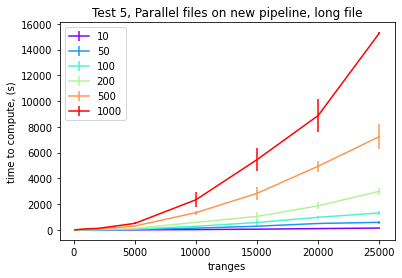

In [93]:
df_plot = df_times5
df_plot["range"] = df_plot['range'].astype(int)
df_plot['time1'] = df_plot['time1'].astype(int)
df_plot['tmax'] = df_plot['tmax'].astype(int)

# plotting
ranges = df_plot['range'].unique()
tmaxes = df_plot['tmax'].unique()
tmaxes.sort()
ranges.sort()

for i, tmax in enumerate(tmaxes):
    df_tmp = df_plot[df_plot['tmax'] == tmax]
    means_tmp = []
    std_tmp = []
    for r in ranges:
        means_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].mean())
        std_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].std())
    plt.errorbar(ranges, means_tmp, yerr=std_tmp, color=colors[i], label = tmax)

plt.title("Test 5, Parallel files on new pipeline, long file")
plt.xlabel("tranges")
plt.ylabel("time to compute, (s)")
plt.legend()
#plt.yscale('log')
#plt.xscale('log')

plt.show()

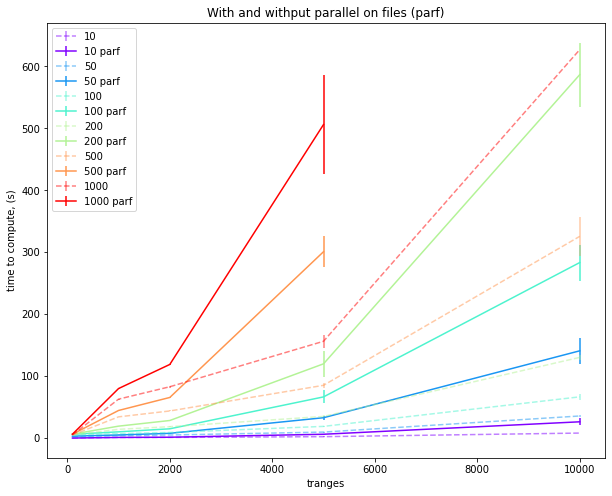

In [87]:
## compare
plt.figure(figsize=(10,8))

df_plot1 = df_times41
df_plot2 = df_times5


# plotting
df_plot1["range"] = df_plot1['range'].astype(int)
df_plot1['time1'] = df_plot1['time1'].astype(int)
df_plot1['tmax'] = df_plot1['tmax'].astype(int)

ranges = df_plot1['range'].unique()
tmaxes = df_plot1['tmax'].unique()
tmaxes.sort()
ranges.sort()

colors = plt.cm.rainbow(np.linspace(0, 1, tmaxes.shape[0]))


for i, tmax in enumerate(tmaxes):
    df_tmp = df_plot1[df_plot1['tmax'] == tmax]
    means_tmp = []
    std_tmp = []
    for r in ranges:
        means_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].mean())
        std_tmp.append(df_tmp[df_tmp['range'] == r]['time1'].std())
    
    df_tmp2 = df_plot2[df_plot2['tmax'] == tmax]
    means_tmp2 = []
    std_tmp2 = []
    for r in ranges:
        means_tmp2.append(df_tmp2[df_tmp2['range'] == r]['time1'].mean())
        std_tmp2.append(df_tmp2[df_tmp2['range'] == r]['time1'].std())
    
    plt.errorbar(ranges, means_tmp, yerr=std_tmp, color=colors[i],   fmt='--', alpha=0.5, label = tmax)
    plt.errorbar(ranges, means_tmp2, yerr=std_tmp2, color=colors[i], label = str(tmax) + " parf")

plt.title("With and withput parallel on files (parf)")
plt.xlabel("tranges")
plt.ylabel("time to compute, (s)")
plt.legend()
#plt.yscale('log')

plt.show()

## Testing Graphs

In [42]:
curr_data.x_slopes.shape

(4, 5000, 8, 8)

In [37]:
t = np.arange(tmax)
#center_peak_x = curr_data.acor_x[:, :, 7, 7]
#center_peak_y = curr_data.acor_y[:, :, 7, 7]
center_peak_avg = curr_data.avg_acor()[:, :, 7, 7]

p_cmap = cm.get_cmap('Purples', 8)
o_cmap = cm.get_cmap('Oranges', 8)
g_cmap = cm.get_cmap('Greens', 8)

plt.figure(figsize=(10,8))

for i in range(3): 
    c_float = (i+1)/5
    #plt.plot(t, center_peak_x[i][t], label = "Sx WFS" + str(i), linestyle=':', color = p_cmap(c_float))
    #plt.plot(t, center_peak_y[i][t], label = "Sy WFS" + str(i), linestyle=':', color = o_cmap(c_float))
    #plt.plot(t, center_peak_avg[i][t], label = "WFS" + str(i), color = g_cmap(c_float))
    
plt.title('WFS corr peak vs time, X and Y correlations')
plt.ylabel('Intensity')
plt.xlabel('time')
plt.legend(loc = 'upper right')

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [ ]:
curr_data.acor_x

In [ ]:
## A Real correlation 

t0 = time.time()
print("Starting ACor")
curr_data.acor_gen()
t1 = time.time()
print("... Finished in ", str(t1-t0))

curr_data.ccor = False
print("Starting XCor")
curr_data.ccor_gen()
t2 = time.time()
print("... Finished in ", str(t2-t1))

print("Writing Fits File")
curr_data.fits_write()
t3 = time.time()
print("... Finished in ", str(t3-t2))

# Pulling Correlated data

In [2]:
p_file = "/home/emcewen/test_lengths/fits/20180601_aocb0040o_tmax2000_stt.fits"
pull_data = Cor.Correlator("", "", "", f_file = p_file)

In [3]:
pull_data.wfs_mag

[None, None, None, None, None]

In [92]:
avg_acor[:, 0, 7, 7]

array([3.29952145e-01, 3.49581541e-01, 2.34205831e-01, 6.51520917e-28,
       2.87199717e-01])

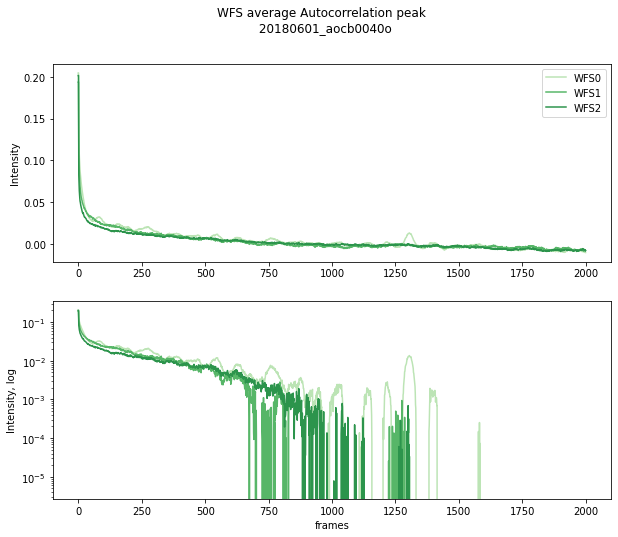

In [59]:
# Creating subplots
t = np.arange(2000)
avg_acor = (pull_data.acor_x + pull_data.acor_y)/2
center_peak_avg = avg_acor[:, :, 7, 7]

c_min = 100
c_max = 500
center_avg = np.average(center_peak_avg[:2], axis=0)
f1, f2 = Linear_fit(t[c_min:c_max], np.log(center_avg)[c_min:c_max])

g_cmap = cm.get_cmap('Greens', 8)
fig,a =  plt.subplots(2,1,figsize=(10,8))

# No log
for i in range(3): 
    c_float = (i+2)/6
    a[0].plot(t, center_peak_avg[i][t], label = "WFS" + str(i), color = g_cmap(c_float))
    a[1].plot(t, center_peak_avg[i][t], label = "WFS" + str(i), color = g_cmap(c_float))

a[1].plot(t, Linear_est(t, f1[0], f1[1]))

a[0].legend(loc = 'upper right')
a[0].set_ylabel('Intensity')
a[1].set_yscale('log')
a[1].set_ylabel('Intensity, log')
a[1].set_xlabel('frames')

fig.suptitle(f'WFS average Autocorrelation peak \n {pull_data.name}')
plt.show()

## Need to add power fits 

In [5]:
# old fitting code:
import scipy.optimize as opt

# Linear Fits
def Linear_tot(x, y):
    a, b = Linear_Fit(x, y)
    a_err, b_err = Linear_err(x, y, a, b)
    return np.array([a, a_err, b, b_err])

def Linear(x, a, b):
    return a * x + b

def Linear_Fit(x, y):
    # returns [slope, intercept]
    # the optimized curve returns the optimized abc values for Gaussian
    # [height, position of peak center (mean), standard deviation]
    popt, pcov = opt.curve_fit(Linear, x, y)
    return popt[0], popt[1]
    
def Linear_fit(x, y):
    # returns fit
    return opt.curve_fit(Linear, x, y)
    
def Linear_est(x, a, b):
    #returns y estimates
    y_est = [Linear(xi, a, b) for xi in x]
    return y_est

#### Ply fit:

def Poly(x, a, b):
    return b*x**a

def Poly_est(x, a, b):
    #returns y estimates
    y_est = [Poly(xi, a, b) for xi in x]
    return y_est

def Poly_fit(x, y):
    # returns [slope, intercept]
    # the optimized curve returns the optimized abc values for Gaussian
    # [height, position of peak center (mean), standard deviation]
    return opt.curve_fit(Poly, x, y)

In [26]:
# mask last wfs
pull_data.active_wfs = [True, True, True, False]
# average, masking on active wfs
center_avg = np.average(center_peak_avg[pull_data.active_wfs], axis=0)

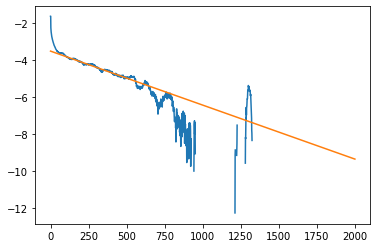

In [39]:
t = np.arange(2001)

c_min = 100
c_max = 500
pull_data.active_wfs = [True, True, True, False]
center_avg = np.average(center_peak_avg[pull_data.active_wfs], axis=0)
f1, f2 = Linear_fit(t[c_min:c_max], np.log(center_avg)[c_min:c_max])

plt.plot(t, np.log(center_avg))
plt.plot(t, Linear_est(t, f1[0], f1[1]))


(array([-2.92139483e-03, -3.49790347e+00]),
 array([[ 4.67440058e-10, -1.39998297e-07],
        [-1.39998297e-07,  4.81619852e-05]]))

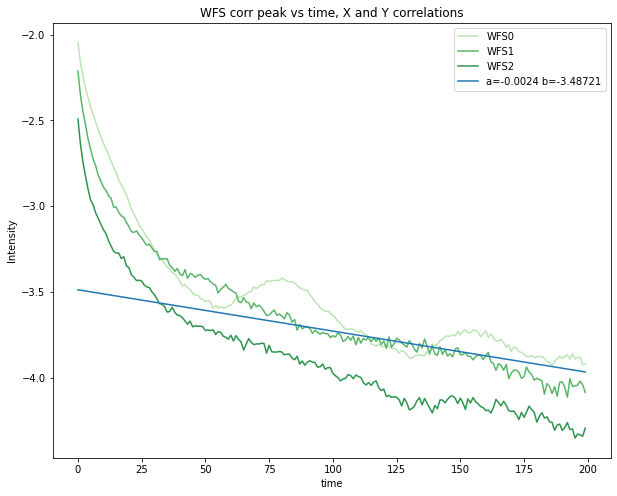

In [53]:
tmax = 200
t = np.arange(tmax)
avg_acor = (pull_data.acor_x + pull_data.acor_y)/2
center_peak_avg = avg_acor[:, 2:, 7, 7]

c_min = 100
c_max = 200
center_avg = np.average(center_peak_avg[:2], axis=0)
f1, f2 = Linear_fit(t[c_min:c_max], np.log(center_avg)[c_min:c_max])

g_cmap = cm.get_cmap('Greens', 8)
plt.figure(figsize=(10,8))

for i in range(3): 
    c_float = (i+2)/6
    plt.plot(t, np.log(center_peak_avg[i][t]), label = "WFS" + str(i), color = g_cmap(c_float))
    
plt.plot(t, Linear_est(t, f1[0], f1[1]), label = f"a={np.around(f1[0],5)} b={np.around(f1[1],5)}")
    

plt.title('WFS corr peak vs time, X and Y correlations')
plt.ylabel('Intensity')
plt.xlabel('time')
plt.legend(loc = 'upper right')

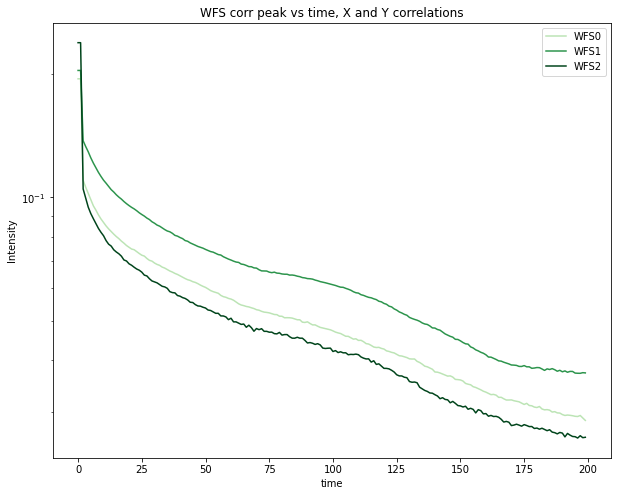

In [56]:
t = np.arange(tmax)

g_cmap = cm.get_cmap('Greens', 8)

plt.figure(figsize=(10,8))

for i in range(3): 
    c_float = (i+1)/3
    #plt.plot(t, center_peak_x[i][t], label = "Sx WFS" + str(i), linestyle=':', color = p_cmap(c_float))
    #plt.plot(t, center_peak_y[i][t], label = "Sy WFS" + str(i), linestyle=':', color = o_cmap(c_float))
    plt.plot(t, center_peak_avg[i][t], label = "WFS" + str(i), color = g_cmap(c_float))
    
plt.title('WFS corr peak vs time, X and Y correlations')
plt.ylabel('Intensity')
plt.xlabel('time')
plt.yscale('log')
plt.legend(loc = 'upper right')